# Dipole
This example reproduces the topology constraint.

In [8]:
from quadcoil import quadcoil

from simsopt.mhd import Vmec
from simsopt import load
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve
import jax
import vmecpp
import os
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready, devices, config
import time
devices()

[CudaDevice(id=0), CudaDevice(id=1)]

## Loading files

In [9]:
# Loading muse++ equilibrium into VMEC
# filename_pp = "wout_muse++.nc"
# equil_pp = Vmec(filename_pp, keep_all_files=True)
# plasma_surface = equil_pp.boundary
# net_poloidal_current_amperes = equil_pp.external_current()

# Loading NCSX
winding_surface, plasma_surface = load('surfaces.json')
net_poloidal_current_amperes = 11884578.094260072
mpol = 4
ntor = 4
jax.config.update('jax_enable_x64', False)

# Problem settings

In [10]:
# Settings 
separation = 0.1
mpol = 12
ntor = 12
nfp = plasma_surface.nfp
plasma_M_theta = 16
plasma_N_phi = 32

## Running a REGCOIL scan

i = 1.0000000000000001e-20 | time = 40.85532736778259


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 3.3598182862837875e-20 | time = 8.611785173416138


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 1.1288378916846929e-19 | time = 8.366899251937866


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 3.792690190732238e-19 | time = 8.676771640777588


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 1.2742749857031323e-18 | time = 8.572693586349487


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 4.281332398719396e-18 | time = 8.601755857467651


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 1.4384498882876658e-17 | time = 8.527229070663452


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 4.8329302385717323e-17 | time = 8.150677919387817


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 1.6237767391887176e-16 | time = 7.918380498886108


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 5.455594781168514e-16 | time = 7.848557472229004


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 1.8329807108324375e-15 | time = 7.720330476760864


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 6.158482110660254e-15 | time = 7.667034149169922


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 2.0691380811147903e-14 | time = 7.531986236572266


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 6.95192796177559e-14 | time = 8.02016568183899


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 2.335721469090121e-13 | time = 8.348828554153442


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 7.847599703514622e-13 | time = 7.509155035018921


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 2.6366508987303555e-12 | time = 7.501664161682129


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 8.858667904100831e-12 | time = 7.4877543449401855


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 2.976351441631313e-11 | time = 7.432332277297974


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


i = 9.999999999999999e-11 | time = 7.614881753921509


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


QUADCOIL avg time: 9.648210525512695 (s)
QUADCOIL max time: 40.85532736778259 (s)
REGCOIL avg time: 13.139244949817657 (s)
REGCOIL max time: 44.38016748428345 (s)
Quadcoil seems to be more well-behaved than regcoil.
quadcoil f_B 0.0077862614
regcoil  f_B 0.90779996


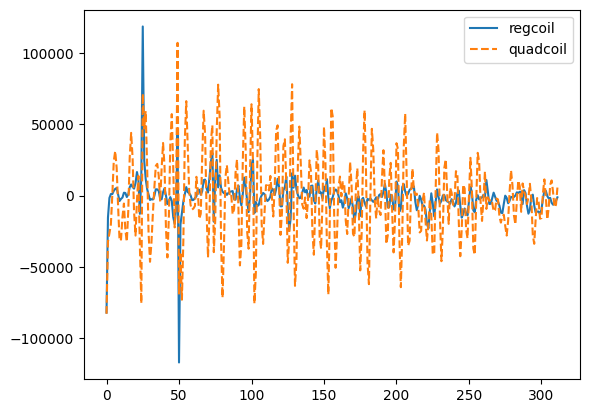

In [16]:
if not os.path.exists('regcoil.npy'):
    # We scan the REGCOIL regularization factor and recover the 
    # dipole distribution Caoxiang's paper chose
    f_B_test_list = []
    phi_test_list = []
    f_K_test_list = []
    time_quadcoil_list = []
    time_regcoil_list = []
    phi_ans_list = []
    f_B_ans_list = []
    f_K_ans_list = []
    for i in 10**np.linspace(-20, -10, 20):
        # Run QUADCOIL first
        time1 = time.time()
        regcoili_out_dict, regcoili_qp, regcoili_phi_mn, status = quadcoil(
            nfp=plasma_surface.nfp,
            stellsym=plasma_surface.stellsym,
            mpol=mpol,
            ntor=ntor,
            plasma_dofs=plasma_surface.get_dofs(),
            plasma_mpol=plasma_surface.mpol,
            plasma_ntor=plasma_surface.ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            plasma_coil_distance=separation,
            objective_name=('f_B', 'f_K'),
            objective_weight=np.array([1., i]),
            objective_unit=(1., 1.),
            metric_name=('f_B', 'f_K'),
        )
    
        phi_test_list.append(regcoili_phi_mn)
        f_B_test_list.append(regcoili_out_dict['f_B']['value'])
        f_K_test_list.append(regcoili_out_dict['f_K']['value'])
        time2 = time.time()
        time_quadcoil_list.append(time2-time1)
        print('i =', i, '| time =', time2-time1)
    
        wsi = regcoili_qp.winding_surface.to_simsopt()
        psi = regcoili_qp.plasma_surface.to_simsopt()
        cpi = CurrentPotentialFourier(
            wsi, mpol=mpol, ntor=ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            stellsym=True)
        cpsti = CurrentPotentialSolve(cpi, psi, 0)
        regcoili_phi_mn_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(i)
        time2 = time.time()
        time_regcoil_list.append(time2-time1)
        phi_ans_list.append(regcoili_phi_mn_ans)
        f_B_ans_list.append(regcoili_f_B_ans)
        f_K_ans_list.append(regcoili_f_K_ans)
        
    print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
    print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
    print('REGCOIL avg time:', np.average(time_regcoil_list), '(s)')
    print('REGCOIL max time:', np.max(time_regcoil_list), '(s)')
    time_regcoil_list = np.array(time_regcoil_list)
    phi_ans_list = np.array(phi_ans_list)
    f_B_ans_list = np.array(f_B_ans_list)
    f_K_ans_list = np.array(f_K_ans_list)
    time_quadcoil_list = np.array(time_quadcoil_list)
    phi_test_list = np.array(phi_test_list)
    f_B_test_list = np.array(f_B_test_list)
    f_K_test_list = np.array(f_K_test_list)
    jnp.save('regcoil.npy',{
        'regcoili_qp': regcoili_qp,
        'time_regcoil_list': time_regcoil_list,
        'phi_ans_list': phi_ans_list,
        'f_B_ans_list': f_B_ans_list,
        'f_K_ans_list': f_K_ans_list,
        'time_quadcoil_list': time_quadcoil_list,
        'phi_test_list': phi_test_list,
        'f_B_test_list': f_B_test_list,
        'f_K_test_list': f_K_test_list,
    })
    # Is quadcoil really well-behaved than regcoil?
    print('Quadcoil seems to be more well-behaved than regcoil.')    
    from quadcoil.objective import f_B
    print('quadcoil f_B', f_B(regcoili_qp, phi_test_list[0]))
    print('regcoil  f_B', f_B(regcoili_qp, phi_ans_list[0]))
    plt.plot(phi_test_list[0], label='regcoil')
    plt.plot(phi_ans_list[0], label='quadcoil', linestyle='dashed')
    plt.legend()
    plt.show()
else:
    dict = jnp.load('regcoil.npy', allow_pickle=True).item()
    regcoili_qp = dict['regcoili_qp']
    time_regcoil_list = dict['time_regcoil_list']
    phi_ans_list = dict['phi_ans_list']
    f_B_ans_list = dict['f_B_ans_list']
    f_K_ans_list = dict['f_K_ans_list']
    time_quadcoil_list = dict['time_quadcoil_list']
    phi_test_list = dict['phi_test_list']
    f_B_test_list = dict['f_B_test_list']
    f_K_test_list = dict['f_K_test_list']

f_K at the inflection point: 34650090000000.0
f_B at the inflection point: 0.008624175


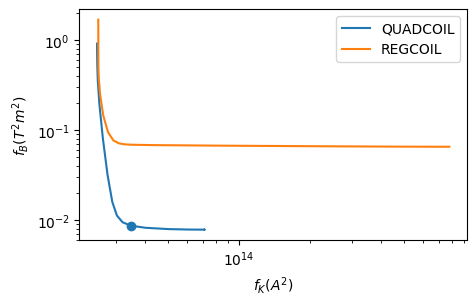

In [26]:
# inflection point
i_infl = np.argmin(f_K_test_list * f_B_test_list)
plt.figure(figsize=(5,3))
plt.plot(f_K_test_list, f_B_test_list, label='QUADCOIL')
plt.plot(f_K_ans_list, f_B_ans_list, label='REGCOIL')
plt.ylabel('$f_B(T^2m^2)$')
plt.xlabel('$f_K(A^2)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.scatter(f_K_test_list[i_infl], f_B_test_list[i_infl])
print('f_K at the inflection point:', f_K_test_list[i_infl])
print('f_B at the inflection point:', f_B_test_list[i_infl])
f_B_target = f_B_test_list[i_infl]
phi_regcoil = phi_test_list[i_infl]

## Defining the QUADCOIL problem

In [18]:
# Calculating normalization factors
from quadcoil.objective import f_max_Phi2, f_B, f_max_Phi, Phi
# Auto-normalization will not work for dipole objectives,
# because they are zero when Phi is 0.
# Therefore, we choose instead to normalize
# using the Phi measured from the inflection point.
unit_Phi2 = f_max_Phi2(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^2) =', unit_Phi2, 'At the inflection point.')
unit_Phi = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi) =', unit_Phi, 'At the inflection point.')

Max(Phi^2) = 286467060000.0 At the inflection point.
Max(Phi) = 535226.2 At the inflection point.


In [19]:
# Solving with the quadcoil default function
out_dict, qp, phi_mn, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_max_Phi',
    objective_name='f_max_Phi2', # Minimizing peak dipole density
    objective_unit=unit_Phi2, # under an f_B constraint
    constraint_name=('f_B',),
    constraint_type=('<=',),
    constraint_unit=(f_B_target,),
    constraint_value=np.array([f_B_target,]),
)

<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:21: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_3193170/2307561423.py:17: SyntaxWarning: invalid escape sequence '\P'
  axes[0].set_title('REGCOIL\n$\Phi_{max}$='+str(int(f_Phi_crtl))+'A')
/tmp/ipykernel_3193170/2307561423.py:21: SyntaxWarning: invalid escape sequence '\P'
  axes[1].set_title('QUADCOIL\n$\Phi_{max}$='+str(int(f_Phi_1))+'A')


f_B from REGCOIL:       0.008624175
f_B from QUADCOIL:      0.011691017
Max dipole dens from REGCOIL:       535226.2
Max dipole dens from QUADCOIL:      315095.44 41.129 % improvement


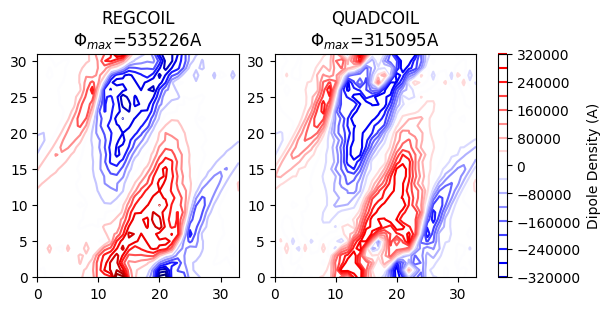

In [20]:
print('f_B from REGCOIL:      ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL:     ', f_B(qp, phi_mn))
f_Phi_crtl = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
f_Phi_1 = f_max_Phi(qp, phi_mn)
print('Max dipole dens from REGCOIL:      ', f_Phi_crtl)
print('Max dipole dens from QUADCOIL:     ', f_Phi_1, round((f_Phi_crtl-f_Phi_1)/f_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(qp, phi_test_list[i_infl])
phi_quadcoil = Phi(qp, phi_mn)
cmin = np.min([phi_regcoil, phi_quadcoil])
cmax = np.max([phi_regcoil, phi_quadcoil])

fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title('REGCOIL\n$\Phi_{max}$='+str(int(f_Phi_crtl))+'A')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title('QUADCOIL\n$\Phi_{max}$='+str(int(f_Phi_1))+'A')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


In [21]:
# Calculating normalization factor for L1 regularized
from quadcoil.objective import f_l1_Phi
unit_l1 = f_l1_Phi(qp, phi_mn)
unit_l1

Array(2643973.2, dtype=float32)

In [22]:
# Solving with the quadcoil default function
l1_out_dict, l1_qp, l1_phi_mn, l1_status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    plasma_coil_distance=separation,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    metric_name='f_B',
    objective_name='f_l1_Phi', # Minimizing the L1 norm of Phi
    objective_unit=unit_l1, # under an f_B, max Phi constraint
    constraint_name=('f_B', 'f_max_Phi',),
    constraint_type=('<=', '<=',),
    constraint_unit=(f_B_target, f_Phi_crtl,),
    constraint_value=np.array([f_B_target, f_Phi_crtl,]),
)

f_B from REGCOIL:       0.008624175
f_B from QUADCOIL:      0.0086246
Max dipole dens from REGCOIL:       2875926.5
Max dipole dens from QUADCOIL:      2685987.5 6.604 % improvement


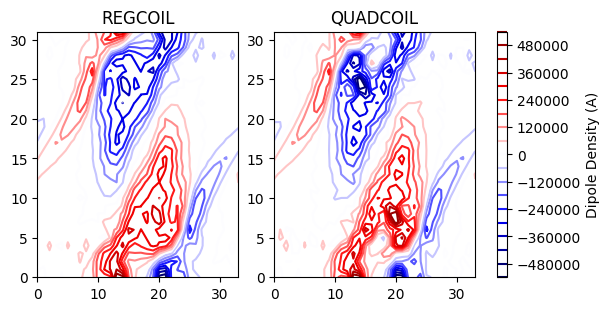

In [30]:
print('f_B from REGCOIL:      ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL:     ', f_B(l1_qp, l1_phi_mn))
f_l1_Phi_crtl = f_l1_Phi(regcoili_qp, phi_test_list[i_infl])
f_l1_Phi_l1 = f_l1_Phi(l1_qp, l1_phi_mn)
print('Max dipole dens from REGCOIL:      ', f_l1_Phi_crtl)
print('Max dipole dens from QUADCOIL:     ', f_l1_Phi_l1, round((f_l1_Phi_crtl-f_l1_Phi_l1)/f_l1_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(qp, phi_test_list[i_infl])
phi_quadcoil_l1 = Phi(l1_qp, l1_phi_mn)
cmin = np.min([phi_regcoil, phi_quadcoil])
cmax = np.max([phi_regcoil, phi_quadcoil])

fig, axes = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[0].set_title('REGCOIL')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil_l1, vmin=cmin, vmax=cmax, cmap = 'seismic', levels=20)
axes[1].set_title('QUADCOIL')



# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density (A)")

plt.show()


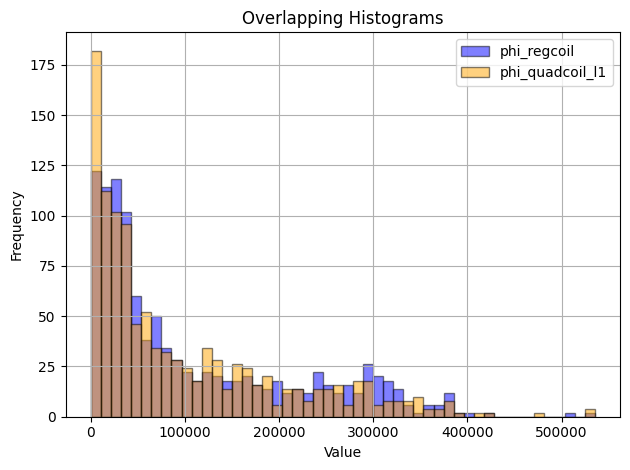

In [31]:
import numpy as np

# Flatten the arrays
phi_reg = np.abs(phi_regcoil.flatten())
phi_quad = np.abs(phi_quadcoil_l1.flatten())

# Define bins based on phi_regcoil
num_bins = 50  # or choose another number of bins
bins = np.histogram_bin_edges(phi_reg, bins=num_bins)

# Plot histograms
plt.hist(phi_reg, bins=bins, alpha=0.5, label='phi_regcoil', color='blue', edgecolor='black')
plt.hist(phi_quad, bins=bins, alpha=0.5, label='phi_quadcoil_l1', color='orange', edgecolor='black')

# Labels and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlapping Histograms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:15: SyntaxWarning: invalid escape sequence '\P'
<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\P'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3193170/1404625868.py:15: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
/tmp/ipykernel_3193170/1404625868.py:16: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('CDF (% $\leq$ x)')


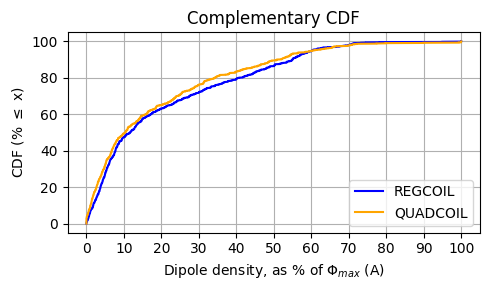

In [32]:

# Sort values
phi_reg_sorted = np.sort(phi_reg) / np.max(phi_reg) * 100
phi_quad_sorted = np.sort(phi_quad) / np.max(phi_reg) *100

# Compute CCDFs
ccdf_reg = np.arange(1, len(phi_reg_sorted)+1) / len(phi_reg_sorted)*100
ccdf_quad = np.arange(1, len(phi_quad_sorted)+1) / len(phi_quad_sorted)*100

# Plot
plt.figure(figsize=(5, 3))
plt.plot(phi_reg_sorted, ccdf_reg, label='REGCOIL', color='blue')
plt.plot(phi_quad_sorted, ccdf_quad, label='QUADCOIL', color='orange')
plt.xticks(np.linspace(0, 100, 11))
# Labels and legend
plt.xlabel('Dipole density, as % of $\Phi_{max}$ (A)')
plt.ylabel('CDF (% $\leq$ x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()